# Debugging:
## This script imports C and Python HDF output for comparison

In [809]:
import h5py
import numpy as np
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('classic')
%matplotlib inline
import subprocess

# Labels and timestamps

In [810]:
figsize_tuple = (12,3)

## Converter

Converts all hdf4 output of RKLM C-code to hdf5.

In [811]:
def convert_c(time,base_suffix,typ,tag,flux,debug=False):
    base_folder_name = "output"

    base_path = base_folder_name + base_suffix
    folder_comp = "low_Mach_gravity_comp/"
    folder_psinc = "low_Mach_gravity_psinc/"
    folder_truth = "low_Mach_gravity_truth/"
#     folder_comp = "low_Mach_gravity_comp_perturbed/"
#     folder_psinc = "low_Mach_gravity_psinc_perturbed/"
#     folder_comp = "low_Mach_gravity_comp_original/"
#     folder_psinc = "low_Mach_gravity_psinc_original/"
    
    if typ == 'PI':
        folder_type = folder_psinc
    if typ == 'COMP':
        folder_type = folder_comp
    if typ == 'TRUTH':
        folder_type = folder_truth

    # Manually list the folder names for each output
    directories = ['S', 'T', 'Y', 'buoy', 'dT', 'dY', 'dp2_c', 'dp2_nodes', 'dpdim', 'drhoY', 'p', 'p2_c', 'p2_nodes', 'rho', 'rhoY', 'rhoe', 'u', 'v', 'vortz', 'w']
    directories += ['rhou', 'rhov', 'rhow', 'rhs']
    directories += ['buoy']

    # And manually list the file names.
    filenames = ['S', 'T', 'Y', 'buoy', 'dT', 'dY', 'dp2_c', 'dp2_n', 'dpdim', 'drhoY', 'p', 'p2_c', 'p2_n', 'rho', 'rhoY', 'rhoe', 'u', 'v', 'vortz', 'w']
    filenames += ['rhou', 'rhov', 'rhow', 'rhs']
    filenames += ['buoy']

    # specify the format extensions for input and output of converter
    hdf_format = '.'+ 'hdf'
    h5_format = '.' + 'h5'

    if flux == True:
        if tag == 'before_advect' or tag == 'after_half_step':
            directories += ['rhoYu', 'rhoYv']
            filenames += ['rhoYu', 'rhoYv']
            
    if tag == 'after_ebnaimp' or tag == 'after_full_step':
        directories += ['wplusx', 'wplusy', 'hcenter', 'p2_full', 'rhs_nodes', 'p2_initial']
        filenames += ['wplusx', 'wplusy', 'hcenter', 'p2_full', 'rhs_nodes', 'p2_initial']

    string_hdf = '_' + time + hdf_format
    string_h5 = '_' + time + h5_format
    full_path = base_path + folder_type

    lst_hdf = []
    lst_h5 = []

    # build list of paths from parameters specified above.
    i = 0
    for directory in directories:
        lst_hdf.append(full_path + directory + '/' + filenames[i] + string_hdf)
        lst_h5.append(full_path + directory + '/' + filenames[i] + string_h5)
        i += 1 

    # print the list of paths
    if debug == True:
        for path in lst_hdf:
            print(path)

    # now, convert the arrays specified in the list of paths
    for item in lst_hdf:
        p = subprocess.call(["./h4toh5convert", item])
        
    return string_h5, full_path

## Import C hdf5 output

Import the test case arrays from the c-output.

In [812]:
def import_c(string_h5, full_path, tag, flux):
    # manually specific folder names
    test_cases_folders = ['p2_c', 'dp2_nodes', 'p', 'p2_nodes', 'rho', 'rhoY', 'rhoe', 'rhou', 'rhov', 'rhow', 'u', 'vortz', 'dpdim', 'T', 'dT', 'Y', 'dY', 'dp2_c']
    test_cases_folders += ['buoy']
    # and filenames
    test_cases_names = ['p2_c', 'dp2_n', 'p', 'p2_n', 'rho', 'rhoY', 'rhoe', 'rhou', 'rhov', 'rhow', 'u', 'vortz', 'dpdim', 'T', 'dT', 'Y', 'dY', 'dp2_c']
    test_cases_names += ['buoy']                    

    if flux == True:
        if tag == 'before_advect' or tag == 'after_half_step':
            test_cases_folders += ['rhoYu','rhoYv']
            test_cases_names += ['rhoYu', 'rhoYv']

    if tag == 'after_ebnaimp' or tag == 'after_full_step':
        test_cases_folders += ['wplusx', 'wplusy', 'hcenter', 'p2_full', 'rhs_nodes', 'p2_initial', 'rhs']
        test_cases_names += ['wplusx', 'wplusy', 'hcenter', 'p2_full', 'rhs_nodes', 'p2_initial', 'rhs']

    test_cases_folders = np.char.array(test_cases_folders)
    test_cases_names = np.char.array(test_cases_names)

    # build paths from folder names and filenames
    test_cases_paths = full_path + test_cases_folders + '/' + test_cases_names + string_h5

    # define empty class as a holder for all the C-hdf5 output.
    class c_output(object):
        def __init__(self):
            None

        def c_out(self):
            for key,value in vars(self).items():
                setattr(self,key,value['Data-Set-2'])

    # get an instance of an empty class to populate it with the C-HDF output as attributes
    c = c_output()

    # populate the class with the C-HDF output as attributes
    i = 0
    for path in test_cases_paths:
        setattr(c,test_cases_folders[i],h5py.File(path, 'r'))
        i += 1


    # run the method to extract array from HDF objects
    c.c_out()
    return c

## Import the Python output

In [813]:
# specify directory where the python hdf5 output is.
# py_directory = "../RKLM_Python/"

# helper function to extract array from hdf file by its name and timestep

def py_out(py_dataset,time):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

def get_filename(base_fn,grid_x,grid_y,size,end_time,suffix):
    fn = "%s_ensemble=%i_%i_%i_%.1f_%s.h5" %(base_fn,size,grid_x,grid_y,end_time,suffix)
    return fn
#     return "output_travelling_vortex_ensemble=" + str(size) + "_" + str(grid_x) + "_" + str(grid_y) + "_" + str(end_time) + suffix + ".h5"

def get_path(directory, filename):
    return directory + filename

def py_out(pyfile,py_dataset,time):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

inner = (slice(2,-2),slice(2,-2))
# inner = (slice(None,),slice(None,))

def ensemble_test_case(time, path, N, attribute, tag):

    file = h5py.File(path,'r')

    array = []
    for n in range(N):
        
        if type(time) == 'float':
            t_label = '_ensemble_mem=%i_%.3d_after_full_step' %(n,time)
        else:
#             t_label = '_ensemble_mem=%i_%s_after_full_step' %(n,time)
            t_label = '_%.3d_%s' %(time,tag)
        array.append(py_out(file,attribute,time=t_label)[inner])

    array = np.array(array)
    array = array.mean(axis=0)

    file.close()
    file.close()
    return array

def diff_plot(py_arr,c_arr,time,att,Nx,Ny):
    fig, ax = plt.subplots(ncols=3, figsize=(15,5))
    im0 = ax[0].imshow(c_arr[inner], origin="lower", aspect='auto')
    ax[0].set_title("(%ix%i), C-output" %(Nx,Ny))
    im1 = ax[1].imshow(py_arr, origin="lower", aspect='auto')
    fig.colorbar(im0,ax=ax[0],shrink=.75)
    ax[1].set_title("(%ix%i), Py-output" %(Nx,Ny))
    fig.colorbar(im1,ax=ax[1],shrink=.75)
    
#     print(c_arr[inner].shape)
#     print(py_arr.shape)
    
    if np.all(py_arr.shape > c_arr[inner].shape):
        diff = np.zeros(py_arr.shape)
        diff[:c_arr[inner].shape[0],:c_arr[inner].shape[1]] = c_arr[inner]
        diff = np.abs(py_arr - diff)
        im2 = ax[2].imshow(diff, origin="lower", aspect='auto')
    else:
        im2 = ax[2].imshow(np.abs(c_arr[inner] - py_arr), origin="lower", aspect='auto')
    ax[2].set_title("abs. diff. between outputs")
    fig.colorbar(im2,ax=ax[2],shrink=.75)
    fig.suptitle(r'Comparing measurements at time step=%.3d for quantity %s' %(time,att), fontsize='16')
    plt.show()

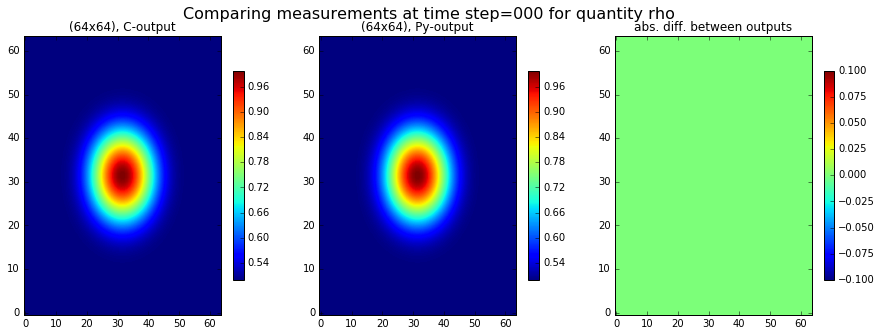

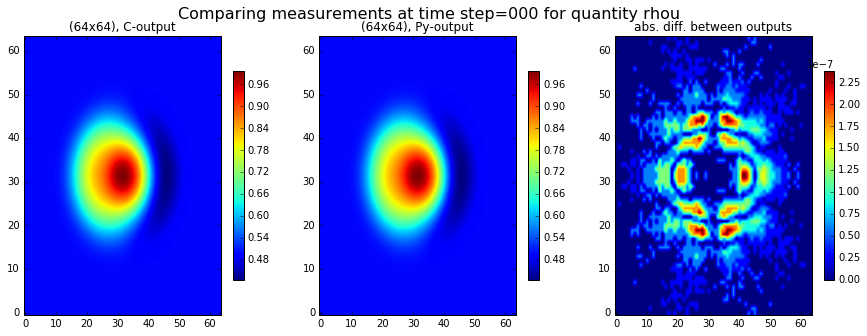

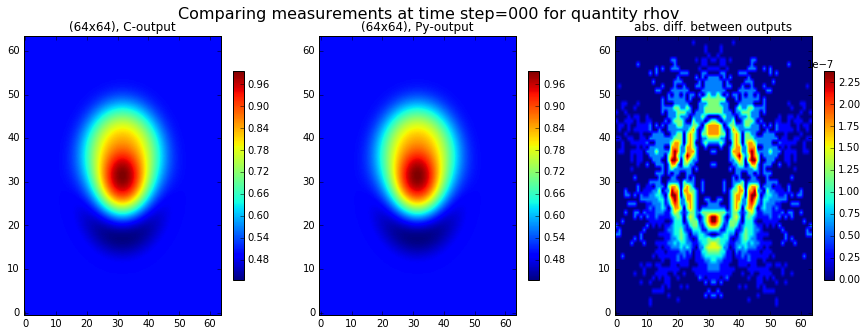

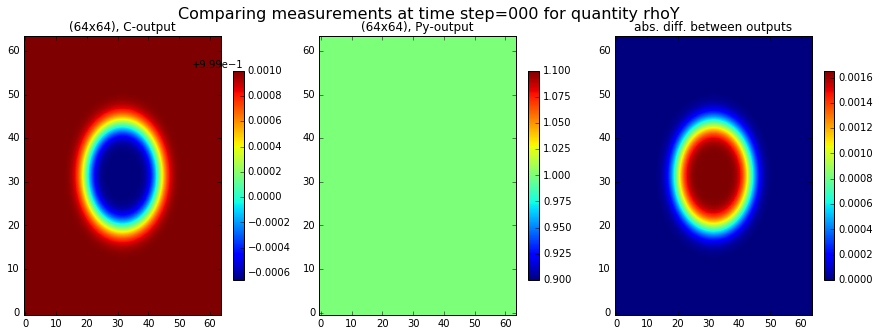

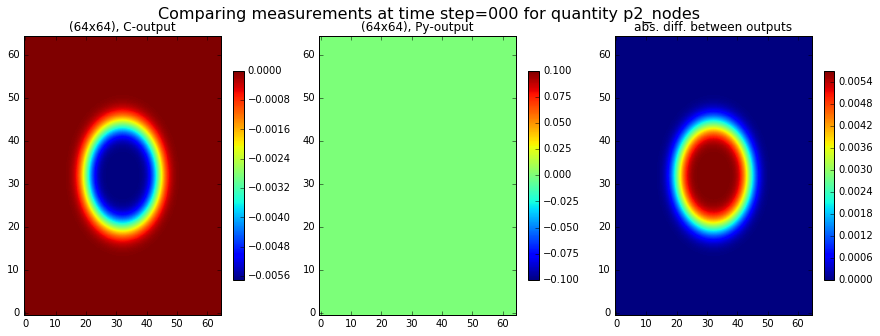

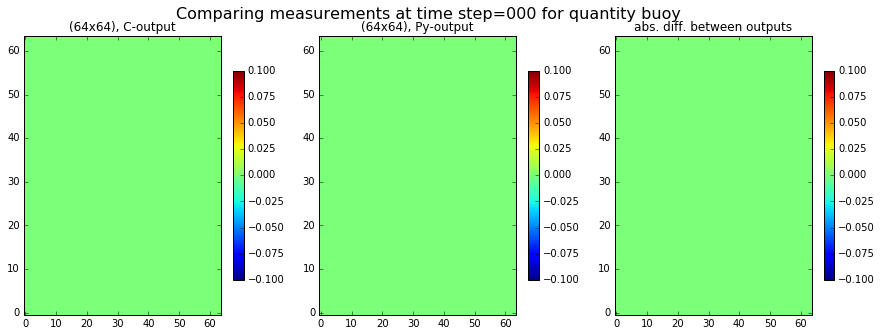

In [895]:
py_time = 0

typ = 'COMP'
typ = 'TRUTH'
# typ = 'PI'

tag = 'ic'
# tag = 'before_advect'
# tag = 'after_advect'
# tag = 'after_ebnaexp'
# tag = 'after_ebnaimp'
# tag = 'after_half_step'
# tag = 'after_efna'
# tag = 'after_full_advect'
# tag = 'after_full_ebnaexp'
# tag = 'after_full_step'

#####################################################
#
# Time labels for C and Python
#
t_label = '%.3d' %py_time
time = t_label + '_' + tag
timem1 = '%.3d_%s' %(py_time-1,tag)
#####################################################

#####################################################
#
# C-output folder names
#
# base_suffix = '_acoustic_wave_high/'
base_suffix = '_internal_long_wave/'
# base_suffix = '_travelling_vortex_3d_48_no_initial_projection/'
base_suffix = '_travelling_vortex_3d_48_with_initial_projection/'
base_suffix = '_travelling_vortex_3d/'
# 
#####################################################

py_directory = "../"
py_directory_suffix = "output_travelling_vortex"
# py_directory_suffix = "output_internal_long_wave"
py_directory += py_directory_suffix + '/'

flux = True

string_h5, full_path = convert_c(time,base_suffix,typ,tag, flux)
c = import_c(string_h5, full_path,tag, flux)

grid_x = 301
grid_y = 10
end_time = 30.0

grid_x = 64
grid_y = 64
end_time = 1.0

ref_size = 1

# if typ == 'COMP': suffix = 'comp'
if typ == 'COMP': suffix = 'truth'
if typ == 'PI': suffix = 'psinc'

py_filename_ref = get_filename(py_directory_suffix,grid_x, grid_y, ref_size, end_time, suffix)
py_path = get_path(py_directory, py_filename_ref)

atts = [
          'rho',
          'rhou',
          'rhov',
          'rhoY',
          'p2_nodes',
          'buoy'
         ]


if tag == 'after_ebnaimp' or tag == 'after_full_step':
    atts += ['rhs_nodes', 'hcenter', 'wplusx', 'wplusy', 'p2_initial', 'p2_full', 'rhs']

# if tag == 'before_advect' or tag == 'after_half_step':
#     atts += ['rhoYu', 'rhoYv']

for att in atts:
    py_arr = ensemble_test_case(py_time,py_path,1,att,tag)

    c_arr = getattr(c,att)[:,:,2]
    diff_plot(py_arr,c_arr,py_time,att,grid_x,grid_y)
    
    if att == 'p2_nodes' and py_time > 0:
        string_h5, full_path = convert_c(timem1,base_suffix,typ,tag, flux)
        cm1 = import_c(string_h5, full_path,tag, flux)
        py_arrm1 = ensemble_test_case(py_time-1,py_path,1,att,tag)
        diff_plot(getattr(cm1,att)[:,:,2],c_arr,py_time,att,grid_x,grid_y)
        diff_plot(py_arrm1,py_arr,py_time,att,grid_x,grid_y)
    
#     print(py_arr[...,:2])
#     print(c_arr[...,:2])

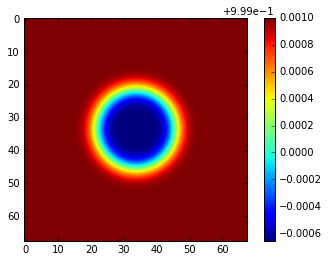

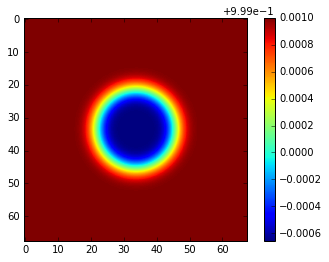

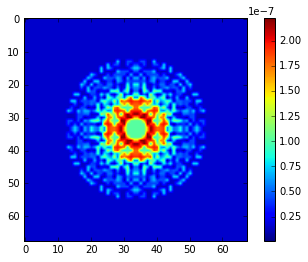

In [906]:
cp2n = getattr(c,'p2_nodes')[:,:,2]
cp2n0 = np.copy(cp2n)# - cp2n.mean()
cp2n = cp2n - cp2n.mean()
# cp2n -= cp2n.min()

# plt.figure()
# plt.imshow(cp2n0)
# plt.colorbar()
# plt.show()

crhoY = getattr(c,'rhoY')[:,:,2]
plt.figure()
plt.imshow(crhoY)
plt.colorbar()
plt.show()

# cp2n += 1.0
# cp2n = cp2n**gm1inv
cp2c = signal.fftconvolve(cp2n,np.ones([2,2]),mode='valid') * 0.25

fac = 1.159823706796567e-05

from scipy import signal
gm1 = 1.4 - 1.
gm1inv = 1./gm1
rhoY = ((crhoY)**gm1 + fac * cp2c)**gm1inv
# rhoY = signal.fftconvolve(rhoY,np.ones([2] * rhoY.ndim),mode='valid') * 0.25
plt.figure()
plt.imshow(rhoY)
plt.colorbar()
plt.show()

# crhoY = getattr(c,'rhoY')[:,:,2]
plt.figure()
plt.imshow(np.abs(rhoY - crhoY))
plt.colorbar()
plt.show()


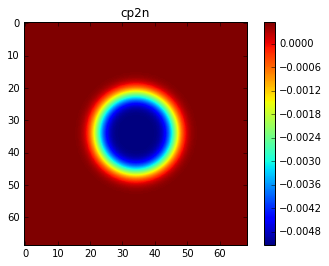

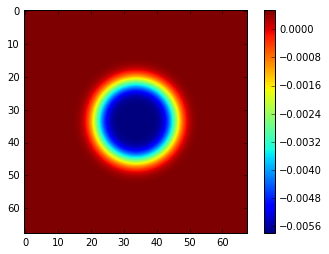

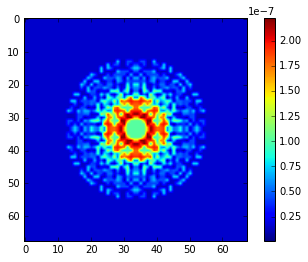

In [931]:
cp2n = getattr(c,'p2_nodes')[:,:,2]
cp2n0 = np.copy(cp2n)# - cp2n.mean()
cp2n = cp2n - cp2n.mean()
# cp2n -= cp2n.min()

# plt.figure()
# plt.imshow(cp2n0)
# plt.colorbar()
# plt.show()

crhoY = getattr(c,'rhoY')[:,:,2]
plt.figure()
plt.imshow(cp2n)
plt.colorbar()
plt.title("cp2n")
plt.show()

# cp2n += 1.0
# cp2n = cp2n**gm1inv
cp2c = signal.fftconvolve(cp2n,np.ones([2,2]),mode='valid') * 0.25

fac = 1.159823706796567e-05

from scipy import signal
gm1 = 1.4 - 1.
gm1inv = 1./gm1
cp2c = ((crhoY)**gm1 - 1.0 + cp2c)
# rhoY = signal.fftconvolve(rhoY,np.ones([2] * rhoY.ndim),mode='valid') * 0.25
plt.figure()
plt.imshow(cp2c)
plt.colorbar()
plt.show()

# crhoY = getattr(c,'rhoY')[:,:,2]
plt.figure()
plt.imshow(np.abs(rhoY - crhoY))
plt.colorbar()
plt.show()

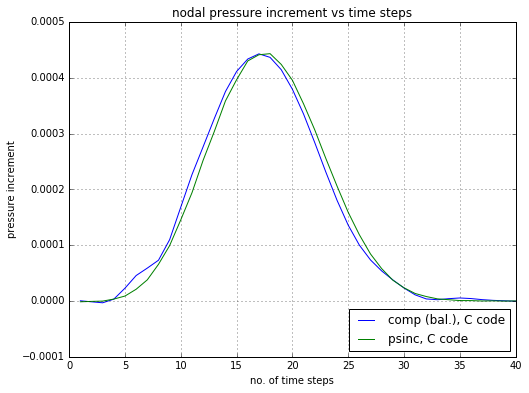

In [864]:
probe = []
probet = []
probep = []
loc0 = 32
loc1 = 32
for carr in carrs:
    probe.append(carr[loc0,loc1])
    
for ctarr in ctarrs:
    probet.append(ctarr[loc0,loc1])
    
for cparr in cparrs:
    probep.append(cparr[loc0,loc1])
    
x = np.arange(1,41)

probe_psinc = [-4.16766852e-07,-6.08619303e-07,-1.03702769e-06,-1.11898407e-06,-1.69640407e-06,-1.57766044e-06,-2.09920108e-06,-1.11339614e-06,1.10827386e-07,5.19910827e-06,1.28620304e-05,2.84104608e-05,4.92618419e-05,8.18534754e-05,1.19826756e-04,1.70257874e-04,2.20939517e-04,2.80115288e-04,3.30120092e-04,3.81096965e-04,4.13513742e-04,4.40027099e-04,4.43348428e-04,4.37245704e-04,4.11213608e-04,3.77084594e-04,3.31179646e-04,2.82633817e-04,2.31205267e-04,1.83405427e-04,1.38962539e-04,1.02073755e-04,7.10626482e-05,4.81653260e-05,3.03973502e-05,1.91010477e-05,1.07118976e-05,6.46532862e-06,3.12112388e-06,2.09594145e-06]
plt.figure(figsize=(8,6))
# plt.plot(x,np.diff(probe), label='comp (unbal.)')
plt.plot(x,np.diff(probet), label='comp (bal.), C code')
plt.plot(x,np.diff(probep), label='psinc, C code')
# plt.plot(x,probe_psinc, label='psinc, Python code')
plt.xlabel('no. of time steps')
plt.ylabel('pressure increment')
plt.title('nodal pressure increment vs time steps')
plt.legend(loc='lower right')
plt.grid()
plt.show()